## Accrual Anomaly

Accrual is the component of the income which is not received in cash. Therefore, there is a risk of the cash not being realized. Businesses can use this to artificially sore up their earnings. Stocks where earnings are dominated by accruals are expected to fall (potential losers) relative to the stocks where earnings are dominated by cash (potential winners). 

## Accrual Anomaly Trading Srategy

Based on the paper titled "Do stock prices fully reflect information in accruals and cash flows about future earnings" by Richard G. Sloan in 1996.\
The idea behind accrual anomaly trading strategy is that in the short-term markets fail to distinguish between earnings driven by accruals and earnings driven by cash, but after some time correct for the anomaly.

### Calculating Accruals

Accruals  = ($\Delta$CA - $\Delta$Cash) - ($\Delta$CL - $\Delta$STD - $\Delta$TP) - Dep.

where,\
$\Delta$CA = Change in Current Assets\
$\Delta$Cash = Change in Cash and Cash Equivalents\
$\Delta$CL = Change in Current Liabilities\
$\Delta$STD = Change in Short-Term Debt\
$\Delta$TP = Change in Tax Payable\
Dep. = Depreciation expense

Income = Income From Continuing Operations / Average Total Assets

Accrual Component of Income = Accruals / Average Total Assets\
Cash Component of Income = Income - Accrual Component

**Steps of trading strategy:**
1. Compute the accrual (or cash) components for each company.
2. Sort the companies based on accrual (or cash) components
3. Divide the companies into deciles based on the sorted accrual (or cash) components.
4. Long the low-accrual component companies and short the high-accrual component comapnies (or long the high-cash component companies and short the low-cash component companies)

### Importing the necessary modules

In [1]:
import pandas as pd
from bs4 import BeautifulSoup
import bs4
import requests
from datetime import date
import plotly.express as px
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from format import format

### Getting the list of stocks from NASDAQ

In [10]:
# getting a list of all the stocks from NASDAQ with Market Cap > 0

df = pd.read_csv('nasdaq_screener.csv')
df = df[df['Market Cap'] > 0]
df.reset_index(inplace=True, drop=True)
stocks = list(df['Symbol'])
len(stocks)

5743

### Functions for web-scraping financial statement tables

In [42]:
# functions for web-scraping financial statement tables from marketwatch.com


def get_table_simple(table,is_table_tag=True):
    '''
    This function will use an html table element and will return 
    a list of lists representing the table
    
    inputs:
    table : an html element
    is_table_tag :  True or False (whether the table is an actual html table 
    element or a simple rows and columns separated by div elements.
    
    output : returns the table in a list of lists form
    '''
    elems = table.find_all('tr') if is_table_tag else get_children(table)
    table_data = list()
    for row in elems:
        row_data = list()
        row_elems = get_children(row)
        for elem in row_elems:
            text = elem.text.strip().replace("\n","")
            text = remove_multiple_spaces(text)
            if len(text)==0:
                continue
            row_data.append(text)
        table_data.append(row_data)
    return table_data

def get_children(html_content):
    return [item for item in html_content.children if type(item)==bs4.element.Tag or len(str(item).replace("\n","").strip())>0]

def remove_multiple_spaces(string):
    if type(string)==str:
        return ' '.join(string.split())
    return string



# function for reading balance sheet data from marketwatch.com using a stock ticker
def get_balance_sheet_data(ticker,yr):
    '''
    The function returns a dictionary of important financial measures for a particular year 
    obtained from the balance sheet of the firm with stock ticker 'ticker'
    
    inputs:
    ticker: stock ticker of the firm
    yr: The year in string notation (e.g. '2020')
    
    output:
    returns a dictionary of the important financial measures 
    (viz. total assets, total current assets, total liabilities, total current liabilities, 
    long-term debt and total common equity)
    '''
    
    urlbalancesheet = 'https://www.marketwatch.com/investing/stock/'+ticker+'/financials/balance-sheet'
    text_soup_balancesheet = BeautifulSoup(requests.get(urlbalancesheet).text,"lxml") #read in
    tables_balancesheet = text_soup_balancesheet.findAll('div', {'class': 'financials'})
    
    bs_assets_table = get_table_simple(tables_balancesheet[0],is_table_tag=True)
    bs_assets_table[0].remove('5-year trend')
    df_assets = pd.DataFrame.from_records(bs_assets_table[1:],columns=bs_assets_table[0])
    df_assets.rename(columns={'ItemItem':'Item'}, inplace=True)
    df_assets['Item'] = df_assets['Item'].astype(str).apply(lambda x: x[:len(x)//2])
    
    bs_liabilities_table = get_table_simple(tables_balancesheet[1],is_table_tag=True)
    bs_liabilities_table[0].remove('5-year trend')
    df_liabilities = pd.DataFrame.from_records(bs_liabilities_table[1:],columns=bs_liabilities_table[0])
    df_liabilities.rename(columns={'ItemItem':'Item'}, inplace=True)
    df_liabilities['Item'] = df_liabilities['Item'].astype(str).apply(lambda x: x[:len(x)//2])
    
    if yr not in df_assets.columns or yr not in df_liabilities.columns:
        return {'CA': None, 'Cash': None, 'CL': None, 'STD': None, 'TP': None, 'TA': None}
    
    TA = text_parse(df_assets[df_assets.Item=='Total Assets'][yr].values[0])
    CA = text_parse(df_assets[df_assets.Item=='Total Current Assets'][yr].values[0])
    Cash = text_parse(df_assets[df_assets.Item=='Cash & Short Term Investments'][yr].values[0])
    
    STD = text_parse(df_liabilities[df_liabilities.Item == 'ST Debt & Current Portion LT Debt'][yr].values[0])
    CL = text_parse(df_liabilities[df_liabilities.Item == 'Total Current Liabilities'][yr].values[0])
    TP = text_parse(df_liabilities[df_liabilities.Item == 'Income Tax Payable'][yr].values[0])
    
    return {'CA': CA, 'Cash': Cash, 'CL': CL, 'STD': STD, 'TP': TP, 'TA': TA}




# function for reading income statement data from marketwatch.com using a stock ticker
def get_income_statement_data(ticker,yr):  
    '''
    The function returns a dictionary of important financial measures for a particular year 
    obtained from the income statement of the firm with stock ticker 'ticker'
    
    inputs:
    ticker: stock ticker of the firm
    yr: The year in string notation (e.g. '2020')
    
    output:
    returns a dictionary of the important financial measures 
    (viz. Net Income, Gross Profit and Total Revenue)
    '''
    
    url_financials = 'https://www.marketwatch.com/investing/stock/'+ticker+'/financials'
    text_soup_financials = BeautifulSoup(requests.get(url_financials).text,"lxml") #read in
    tables_incomestatement = text_soup_financials.findAll('div', {'class': 'financials'})
    
    is_table = get_table_simple(tables_incomestatement[0],is_table_tag=True)
    is_table[0].remove('5-year trend')
    df_is = pd.DataFrame.from_records(is_table[1:],columns=is_table[0])
    df_is.rename(columns={'ItemItem':'Item'}, inplace=True)
    df_is['Item'] = df_is['Item'].astype(str).apply(lambda x: x[:len(x)//2])
    
    if yr not in df_is.columns:
        return {'Income_From_Continuing_Operations': None}
    
    Income_From_Continuing_Operations = text_parse(df_is[df_is['Item']=='Net Income'][yr].values[0])
    
    return {'Income_From_Continuing_Operations': Income_From_Continuing_Operations}




# function for reading cash flow statement data from marketwatch.com using a stock ticker
def get_cash_flow_data(ticker,yr):  
    '''
    The function returns a dictionary of important financial measures for a particular year 
    obtained from the cash flow statement of the firm with stock ticker 'ticker'
    
    inputs:
    ticker: stock ticker of the firm
    yr: The year in string notation (e.g. '2020')
    
    output:
    returns a dictionary of the important financial measures 
    (viz. total cash from operating activities)
    '''
        
    urlcashflow = 'https://www.marketwatch.com/investing/stock/'+ticker+'/financials/cash-flow'
    text_soup_cashflow = BeautifulSoup(requests.get(urlcashflow).text,"lxml") #read in
    tables_cashflow = text_soup_cashflow.findAll('div', {'class': 'financials'})
    cf_table = get_table_simple(tables_cashflow[0],is_table_tag=True)
    
    cf_table[0].remove('5-year trend')
    df_cf = pd.DataFrame.from_records(cf_table[1:],columns=cf_table[0])
    df_cf.rename(columns={'ItemItem':'Item'}, inplace=True)
    df_cf['Item'] = df_cf['Item'].astype(str).apply(lambda x: x[:len(x)//2])
    
    if yr not in df_cf.columns:
        return {'Dep': None}

    Dep = text_parse(df_cf[df_cf['Item']=='Depreciation, Depletion & Amortization'][yr].values[0])
    
    return {'Dep': Dep}

                      
                      



def text_parse(text):
    '''
    This function to convert the string outputs of the 
    financial statements to float values  
    '''
    if len(text) == 2:
        text = text[0]
    text = text.strip('(').strip(')').strip('$').strip(' ')
    if text == '-' or text == '':
        return 0    
    elif text[-1] == 'T':
        return float(text.strip('T'))*1e12
    elif text[-1] == 'B':
        return float(text.strip('B'))*1e9
    elif text[-1] == 'M':
        return float(text.strip('M'))*1e6
    elif text[-1] == 'K':
        return float(text.strip('K'))*1e3
    else:
        return float(text)
        

### Calculating Accrual and cash components of income for all the stocks of the sample

In [128]:
columns = ['symbol', 'TA_cur_year', 'TA_last_year', 'Avg_TA', 'CA_cur_year', 'CA_last_year', 'Delta_CA', 'Cash_cur_year', 'Cash_last_year', 'Delta_Cash', 'CL_cur_year' , 'CL_last_year', 'Delta_CL', 'STD_cur_year', 'STD_last_year', 'Delta_STD', 'TP_cur_year', 'TP_last_year', 'Delta_TP', 'Dep', 'Accruals', 'Income_From_Continuing_Operations', 'Income', 'Accrual_Component','Cash_Component']
Accrual_Cash_Component_df = pd.DataFrame(columns=columns)

for symbol in stocks[4015:]:
    print(symbol)
    
    try:
        # Balance Sheet Data
        bs_data_cur_year = get_balance_sheet_data(symbol,'2020')
        bs_data_last_year = get_balance_sheet_data(symbol,'2019')

        # Income Statement Data
        is_data_cur_year = get_income_statement_data(symbol,'2020')
        is_data_last_year =  get_income_statement_data(symbol,'2019')

        # Cash Flow Data
        cf_data_cur_year = get_cash_flow_data(symbol,'2020')
        cf_data_last_year = get_cash_flow_data(symbol,'2019')
        

        TA_cur_year = bs_data_cur_year['TA']
        TA_last_year = bs_data_last_year['TA']

        CA_cur_year = bs_data_cur_year['CA']
        CA_last_year = bs_data_last_year['CA']
        
        Cash_cur_year = bs_data_cur_year['Cash']
        Cash_last_year = bs_data_last_year['Cash']

        CL_cur_year = bs_data_cur_year['CL']
        CL_last_year = bs_data_last_year['CL']
        
        STD_cur_year = bs_data_cur_year['STD']
        STD_last_year = bs_data_last_year['STD']

        TP_cur_year = bs_data_cur_year['TP']
        TP_last_year = bs_data_last_year['TP']

        Dep = cf_data_cur_year['Dep']
        
        Income_From_Continuing_Operations = is_data_cur_year['Income_From_Continuing_Operations']
        
        financials = [TA_cur_year, TA_last_year, CA_cur_year, CA_last_year, Cash_cur_year, Cash_last_year, CL_cur_year, CL_last_year, STD_cur_year, STD_last_year, TP_cur_year, TP_last_year, Dep, Income_From_Continuing_Operations]

        if None in financials:
            continue

        else:
            Avg_TA = (TA_cur_year + TA_last_year)/2
            Delta_CA = TA_cur_year - TA_last_year
            Delta_Cash = Cash_cur_year - Cash_last_year
            Delta_CL = CL_cur_year - CL_last_year
            Delta_STD = STD_cur_year - STD_last_year
            Delta_TP = TP_cur_year - TP_last_year

            Accruals = (Delta_CA - Delta_Cash) -(Delta_CL - Delta_STD - Delta_TP) - Dep
            Income = Income_From_Continuing_Operations / Avg_TA
            Accrual_Component = Accruals / Avg_TA
            Cash_Component = Income - Accrual_Component


            Accrual_Cash_Component_df = Accrual_Cash_Component_df.append(pd.DataFrame([[symbol, TA_cur_year, TA_last_year, Avg_TA, CA_cur_year, CA_last_year, Delta_CA, Cash_cur_year, Cash_last_year, Delta_Cash, CL_cur_year, CL_last_year, Delta_CL, STD_cur_year, STD_last_year, Delta_STD, TP_cur_year, TP_last_year, Delta_TP, Dep, Accruals, Income_From_Continuing_Operations, Income, Accrual_Component, Cash_Component]],columns=columns),ignore_index=True)
    except IndexError:
        pass

### Results

In [69]:
Accrual_Cash_Component_df

,symbol,TA_cur_year,TA_last_year,Avg_TA,CA_cur_year,CA_last_year,Delta_CA,Cash_cur_year,Cash_last_year,Delta_Cash,...,Delta_STD,TP_cur_year,TP_last_year,Delta_TP,Dep,Accruals,Income_From_Continuing_Operations,Income,Accrual_Component,Cash_Component
0,A,9.630000e+09,9.450000e+09,9.540000e+09,3.420000e+09,3.190000e+09,1.800000e+08,1.440000e+09,1.380000e+09,6.000000e+07,...,-490000000.0,63000000.0,292000000.0,-229000000.0,3.080000e+08,-2.970000e+08,7.190000e+08,0.075367,-0.031132,0.106499
1,AA,1.486000e+10,1.463000e+10,1.474500e+10,4.520000e+09,3.530000e+09,2.300000e+08,1.630000e+09,9.420000e+08,6.880000e+08,...,0.0,91000000.0,104000000.0,-13000000.0,6.530000e+08,-1.324000e+09,1.700000e+08,0.011529,-0.089793,0.101322
2,AAL,6.201000e+10,6.000000e+10,6.100500e+10,1.110000e+10,8.210000e+09,2.010000e+09,7.470000e+09,3.980000e+09,3.490000e+09,...,-120000000.0,0.0,0.0,0.0,2.370000e+09,-2.230000e+09,8.890000e+09,0.145726,-0.036554,0.182280
3,AAOI,4.808100e+08,4.668300e+08,4.738200e+08,2.091700e+08,1.928000e+08,1.398000e+07,5.011000e+07,6.703000e+07,-1.692000e+07,...,14500000.0,0.0,0.0,0.0,2.473000e+07,8.880000e+06,5.845000e+07,0.123359,0.018741,0.104618
4,AAON,4.614400e+08,3.839400e+08,4.226900e+08,2.202500e+08,1.875500e+08,7.750000e+07,8.229000e+07,4.437000e+07,3.792000e+07,...,0.0,0.0,0.0,0.0,2.563000e+07,1.095000e+07,7.901000e+07,0.186922,0.025906,0.161016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2551,ZUMZ,9.142600e+08,5.341900e+08,7.242250e+08,4.125900e+08,3.271800e+08,3.800700e+08,2.512000e+08,1.653300e+08,8.587000e+07,...,61800000.0,4690000.0,5820000.0,-1130000.0,8.367000e+07,2.046000e+08,6.688000e+07,0.092347,0.282509,-0.190162
2552,ZUO,4.022300e+08,3.260500e+08,3.641400e+08,2.572000e+08,2.491400e+08,7.618000e+07,1.719400e+08,1.762500e+08,-4.310000e+06,...,7230000.0,432000.0,1650000.0,-1218000.0,2.045000e+07,2.850200e+07,8.339000e+07,0.229005,0.078272,0.150733
2553,ZVO,1.613100e+08,2.501400e+08,2.057250e+08,7.683000e+07,1.505100e+08,-8.883000e+07,5.701000e+07,9.504000e+07,-3.803000e+07,...,-950000.0,0.0,0.0,0.0,1.140000e+07,-1.049000e+07,4.895000e+07,0.237939,-0.050990,0.288929
2554,ZYME,5.383800e+08,3.682100e+08,4.532950e+08,4.550800e+08,3.118300e+08,1.701700e+08,4.263500e+08,2.989000e+08,1.274500e+08,...,1440000.0,0.0,0.0,0.0,1.028000e+07,3.076000e+07,1.805500e+08,0.398306,0.067859,0.330447


So we get accrual and cash components for 2566 firms. We will now divide the firms into deciles based on the Accrual component values. One can also use the cash component here, taking into account the fact that the potential winners will be the ones with the lowest accrual components (highest cash components) and potential losers will be the ones with the highest accrual components (lowest cash components).

### Distribution of Accrual components

Text(0, 0.5, 'Frequency')

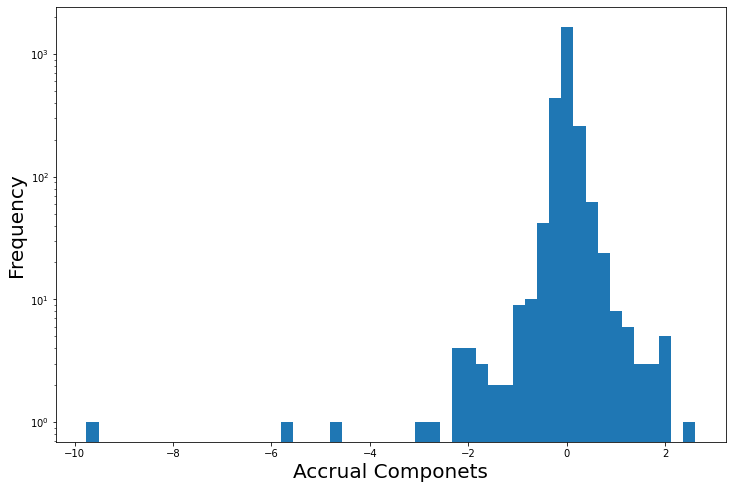

In [122]:
fig, ax = plt.subplots(figsize=(12,8))
Accrual_Cash_Component_df['Accrual_Component'].plot.hist(bins=50,log=True,ax=ax)
ax.set_xlabel('Accrual Componets',fontsize=20)
ax.set_ylabel('Frequency',fontsize=20)

### Dividing the firms into deciles based on their Accrual Components

In [123]:
deciles = [np.quantile(Accrual_Cash_Component_df['Accrual_Component'].values,x) for x in np.arange(0,11)/10]

In [130]:
Accrual_Cash_Component_df['Accrual_Component_decile'] = 0
for i in range(len(deciles)-1):
    Accrual_Cash_Component_df['Accrual_Component_decile'][Accrual_Cash_Component_df['Accrual_Component'].apply(lambda x: x>=deciles[i] and x<deciles[i+1]).values] = i

In [129]:
Accrual_Cash_Component_df['Accrual_Component_decile']

Text(0, 0.5, 'Count')

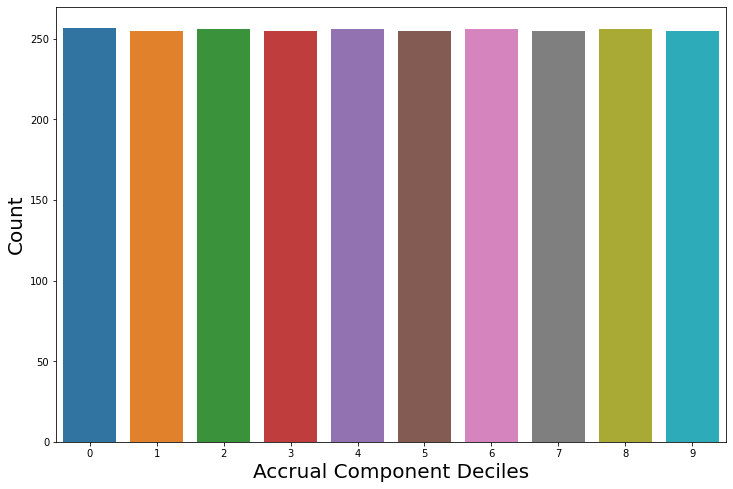

In [127]:
fig, ax = plt.subplots(figsize=(12,8))
sns.countplot(ax=ax,x='Accrual_Component_decile',data=Accrual_Cash_Component_df)
ax.set_xlabel('Accrual Component Deciles',fontsize=20)
ax.set_ylabel('Count',fontsize=20)

### Low-Accrual stocks (Potential Winners)
These are the stocks that belong to the bottommost decile of Accrual components.

In [118]:
Accrual_Cash_Component_df['symbol'][Accrual_Cash_Component_df['Accrual_Component_decile'] == 0]

22       ACB
25      ACER
26      ACHC
60       AEY
70      AGYS
        ... 
2523    YELL
2524    YELP
2525    YETI
2528    YNDX
2536    ZDGE
Name: symbol, Length: 257, dtype: object

### High-Accrual stocks (Potential Losers)
These are the stocks that belong to the topmost decile of Accrual components.

In [119]:
Accrual_Cash_Component_df['symbol'][Accrual_Cash_Component_df['Accrual_Component_decile'] == 9]

9       ABBV
11      ABCM
13       ABG
30      ACMR
46      ADUS
        ... 
2534       Z
2539      ZG
2547    ZNGA
2551    ZUMZ
2555    ZYXI
Name: symbol, Length: 255, dtype: object